In [2]:
import os
import re
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [3]:
LAT_DEFINE = 13.741163338261524
LON_DEFINE = 100.64205151814542

ZOOM_START = 10

In [4]:
gps_data_dir = 'E:/data/gps'
road_data_dir = 'E:/data/road'

In [5]:
tqdm.pandas(desc='working : ')

# Explore gps data

## find interesting road for use in project

### load GPS data
- **Columns**
  - time_stamp => เป็นวันเวลา
  - unit_id => เป็น id ของรถ
  - lat => เป็นค่า latitude
  - lon => เป็นค่า longitude
  - speed => เป็นค่าความเร็ว หน่วยเป็น km/h
  - unit_type => เป็นชนิดของรถ
    - 1 = รถโดยสารประจำทาง
    - 3 = รถโดยสารไม่ประจำทาง
    - 4 = รถโดยสารส่วนบุคคล
    - 5,8,9  = รถบรรทุกส่วนบุคคล
    - 6,7 = รถบรรทุกไม่ประจำทาง

In [18]:
# df_gps = pd.read_csv(gps_data_dir + '/2019/2019-03/2019-03-01_00.zip')
# df_gps.head()

,time_stamp,unit_id,lat,lon,speed,unit_type
0,2019-03-01 00:00:35,0390002000000000000EE085491,13.702763,100.581581,2,7.0
1,2019-03-01 00:00:26,015000500000863835028323652,9.970495,98.642845,0,3.0
2,2019-03-01 00:00:32,0390002000000000000EE107549,19.950153,99.236827,3,8.0
3,2019-03-01 00:00:28,005000600000864507030191018,14.076360,100.520670,0,8.0
4,2019-03-01 00:00:33,025000600000359857080832934,12.516950,99.978370,0,7.0


### load road data
- **Columns**
  - rid => หมายเลขสายถนน
  - rd => เลขถนน
  - km
  - ptype => ชนิดหลัก
  - lat, lon => ข้อมูลพิกัดแบบละเอียด
  - latx, lonx => ข้อมูลพิกัด ทศนิยม 3 ตำแหน่ง
  - angle => องศาของถนน 

In [4]:
# df_road = pd.read_csv(road_data_dir + '/roaddb.csv')
# df_road.head()

,rid,rd,km,ptype,lat,lon,latx,lonx,angle
0,1,3003,0.0,100m,14.492856,100.066108,14.493,100.066,180
1,1,3003,0.1,100m,14.493738,100.066290,14.494,100.066,180
2,1,3003,0.2,100m,14.494619,100.066476,14.495,100.066,179
3,1,3003,0.3,100m,14.495501,100.066658,14.496,100.067,179
4,1,3003,0.4,100m,14.496383,100.066839,14.496,100.067,179


### find interesting road

In [4]:
def get_road_dict(df_road):
    road_list = []
    df_road['coor'] = df_road.progress_apply(lambda row: f"{row['latx']:.3f}, {row['lonx']:.3f}", axis='columns')
    for rd in df_road['rd'].unique():
        coors = df_road[df_road['rd'] == rd]['coor'].to_list()
        road_dict = {
            'rd': rd,
            'coor_list': coors,
        }
        road_list.append(road_dict)
    return road_list

def get_road_interest(df_gps, road_list):
    df_gps = df_gps[df_gps['unit_type'].isin([6, 7])].reset_index(drop=True)
    df_gps = df_gps.drop_duplicates(subset=['unit_id']).reset_index(drop=True)
    df_gps['coor'] = df_gps.progress_apply(lambda row: f"{row['lat']:.3f}, {row['lon']:.3f}", axis='columns')
    for idx in range(len(road_list)):
        count_car = len(df_gps[df_gps['coor'].isin(road_list[idx]['coor_list'])])
        road_list[idx]['count_car'] = count_car

    return road_list

def find_road_interest():
    df_road = pd.read_csv(road_data_dir + '/roaddb.csv')
    df_gps = pd.read_csv(gps_data_dir + '/2019/2019-03/2019-03-08_21.zip', compression='zip')

    try:
        road_list = get_road_dict(df_road)
        road_list = get_road_interest(df_gps, road_list)

        # sort 'count_car' from highest to lowest.
        road_list.sort(key=sort_count, reverse=True)
    except:
        print(f"Error for find road interest")
    finally:
        # clear data in memory
        del df_road
        del df_gps

    return road_list

def sort_count(d):
    """
    function get value for sort list
    """
    return d['count_car']

In [27]:
road_list = find_road_interest()

working : 100%|██████████| 100106/100106 [00:01<00:00, 94106.82it/s]


In [28]:
# show top 10 road number have trucks
for idx in range(10):
    print(f"{road_list[idx]['rd']} : {road_list[idx]['count_car']}")

1 : 2483
4 : 2424
2 : 2247
9 : 1456
41 : 1185
7 : 1134
3901 : 1049
3902 : 1037
304 : 750
32 : 723


## find support point in data

In [6]:
def clean_df_tmp(df_tmp):
    """
    Function for clean dataframe by cleaning condition.
    """
    unit_type = df_tmp['unit_type'].isin([6, 7])
    speed = df_tmp['speed'] == 0

    df_tmp = df_tmp[unit_type & speed].reset_index(drop=True)
    return df_tmp

def load_gps_data():
    """
    Function for load and merge dataframes.
    """
    years_list = ['2019']
    months_list = ['03']
    days_list = ['01']
    df_list = []

    for year in years_list:
        for month in months_list:
            # get list filename in the folder path.
            file_names = os.listdir(gps_data_dir + f"/{year}/{year}-{month}/")
            for day in days_list:
                amount_day = 0
                for file_name in file_names:
                    file_name_part = re.split('-|_', file_name)
                    if len(file_name_part) > 2:
                        # select the day we chose from filename.
                        if file_name_part[2] == day:
                            _tmp = pd.read_csv(gps_data_dir + f"/{year}/{year}-{month}/" + file_name, compression='zip', parse_dates=['time_stamp'])
                            _tmp = clean_df_tmp(_tmp)
                            df_list.append(_tmp)
                            amount_day += 1
                            del _tmp

                    # the data collected was split into 8 sessions per day.
                    if amount_day > 7:
                        break
    
    df_gps = pd.concat(df_list, axis='rows', ignore_index=True)
    return df_gps

def get_road_dict_select(df_road):
    road_list_select = []
    df_road['coor'] = df_road.progress_apply(lambda row: f"{row['latx']:.3f}, {row['lonx']:.3f}", axis='columns')
    for rd in [1, 2, 4, 7, 9, 32, 41, 304, 3901, 3902]:
        coors = df_road[df_road['rd'] == rd]['coor'].to_list()
        road_dict_select = {
            'rd': rd,
            'coor_list': coors,
        }
        road_list_select.append(road_dict_select)
    return road_list_select

def get_point_amount(df_gps, road_list_select):
    point_list = []
    df_gps['coor'] = df_gps.progress_apply(lambda row: f"{row['lat']:.3f}, {row['lon']:.3f}", axis='columns')
    for idx in tqdm(range(len(road_list_select))):
        _tmp = df_gps[df_gps['coor'].isin(road_list_select[idx]['coor_list'])].reset_index(drop=True)
        for coor in road_list_select[idx]['coor_list']:
            _vehicle = _tmp[_tmp['coor'] == coor].reset_index(drop=True)
            _vehicle = _vehicle.drop_duplicates(subset=['unit_id']).reset_index(drop=True)
            point_dict = {
                'rd': road_list_select[idx]['rd'],
                'coor': coor,
                'amount': len(_vehicle)
            }
            point_list.append(point_dict)
            del _vehicle
        del _tmp
    return point_list
        

def find_point():
    df_road = pd.read_csv(road_data_dir + '/roaddb.csv')
    df_gps = load_gps_data()

    try:
        road_list_select = get_road_dict_select(df_road)
        point_list = get_point_amount(df_gps, road_list_select)
        df_point = pd.DataFrame(point_list)
    except:
        print(f"Error for find point")
    finally:
        # clear data in memory
        del df_road
        del df_gps
        del road_list_select
        del point_list

    return df_point

In [7]:
def plot_gps(lat, lon, popup, tooltip, mean, amount):
    if popup is None:
        popup = ['Some detail'] * len(lat)

    map = folium.Map(location=[LAT_DEFINE, LON_DEFINE], zoom_start=ZOOM_START)
    for _lat, _lon, _popup, _tooltip, _amount in zip(lat, lon, popup, tooltip, amount):
        if _amount > mean:
            folium.CircleMarker(
                location = [_lat, _lon],
                radius = 6,
                popup = _popup,
                color = 'blue',
                fill = True,
                fill_color = 'blue',
                fill_opacity = 0.7,
                tooltip = _tooltip
            ).add_to(map)

    display(map)

def visualize_point(df_point):
    mean_list = df_point.groupby(['rd']).mean()['amount'].to_list()
    idx = 0

    for rd in [1, 2, 4, 7, 9, 32, 41, 304, 3901, 3902]:
        _tmp = df_point[df_point['rd'] == rd].reset_index(drop=True)

        lat = _tmp['coor'].apply(lambda row: float(row.split(',')[0])).to_list()
        lon = _tmp['coor'].apply(lambda row: float(row.split(',')[1])).to_list()
        popup = _tmp['rd'].to_list()
        amount = _tmp['amount'].to_list()
        tooltip = _tmp['amount'].apply(lambda row: f"amount: {row}").to_list()
        plot_gps(lat, lon, popup, tooltip, mean_list[idx], amount)
        idx += 1
    

In [8]:
df_point = find_point()

100%|██████████| 10/10 [13:49<00:00, 82.95s/it]


In [9]:
df_point = df_point[df_point['amount'] > 0].reset_index(drop=True)
df_point.groupby(['rd']).mean()

,amount
rd,
1,6.845313
2,7.833971
4,6.618455
7,17.401567
9,11.042042
32,6.222008
41,6.487973
304,6.735426
3901,11.403046


In [ ]:
# visualize_point(df_point)

## DBscan

### find eps for DBScan

In [102]:
def get_eps_with_NN(df_point, rd, n_neighbors):
    # init dataframe for find epsilon
    df_neighbors = df_point.copy()
    df_neighbors = df_neighbors[df_neighbors['rd'] == rd].reset_index(drop=True)
    df_neighbors['lat'] = df_neighbors.apply(lambda row: float(row['coor'].split(',')[0]), axis=1)
    df_neighbors['lon'] = df_neighbors.apply(lambda row: float(row['coor'].split(',')[1]), axis=1)
    df_neighbors = df_neighbors.drop(['rd', 'coor', 'amount'], axis=1)

    # train NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=n_neighbors)
    neighbors_fit = neighbors.fit(df_neighbors)
    distances, _ = neighbors_fit.kneighbors(df_neighbors)

    # sort value for plot
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    # plot
    plt.plot(distances)
    plt.show()

    return df_neighbors

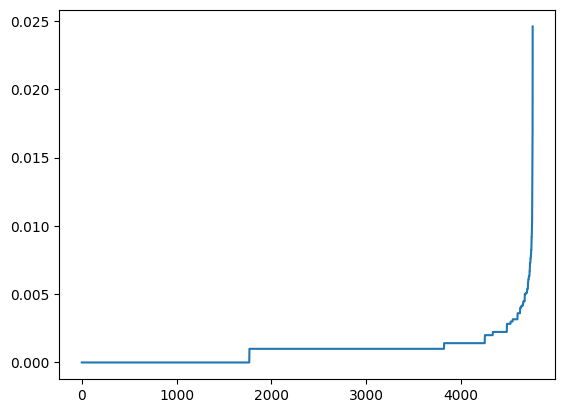

In [103]:
df_neighbors = get_eps_with_NN(df_point, 1, 2)

### DBScan

In [113]:
def cluster_plot(df_tmp, labels):
    # init color for plot
    customPalette = ['#0C0F0A', '#FF206E', '#FBFF12', '#41EAD4', '#5C80BC', '#FB8B24', '#04A777', '#7E8D85', '#B3BFB8', '#6F8695']

    plt.figure(figsize=(20, 20))

    for i, label in enumerate(labels):
        plt.scatter(
            x=df_tmp[df_tmp['label'] == label]['lon'],
            y=df_tmp[df_tmp['label'] == label]['lat'],
            color=customPalette[i % len(customPalette)],
            alpha=1
        )

        plt.annotate(
            label,
            df_neighbors.loc[df_tmp['label'] == label, ['lon', 'lat']].mean(),
            horizontalalignment='center',
            verticalalignment='center',
            size=5,
            weight='bold',
            color='white',
            backgroundcolor=customPalette[i % len(customPalette)]
        )

        plt.plot()

    plt.show()

def dbscan(df_neighbors, eps, min_samples):
    df_tmp = df_neighbors.copy()
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df_tmp)

    df_tmp['label'] = clustering.labels_

    idx_noise = df_tmp[df_tmp['label'] == -1].index
    df_tmp = df_tmp.drop(idx_noise).reset_index(drop=True)

    labels = list(set(df_tmp['label'].to_list()))
    cluster_plot(df_tmp, labels)
    
    return df_tmp

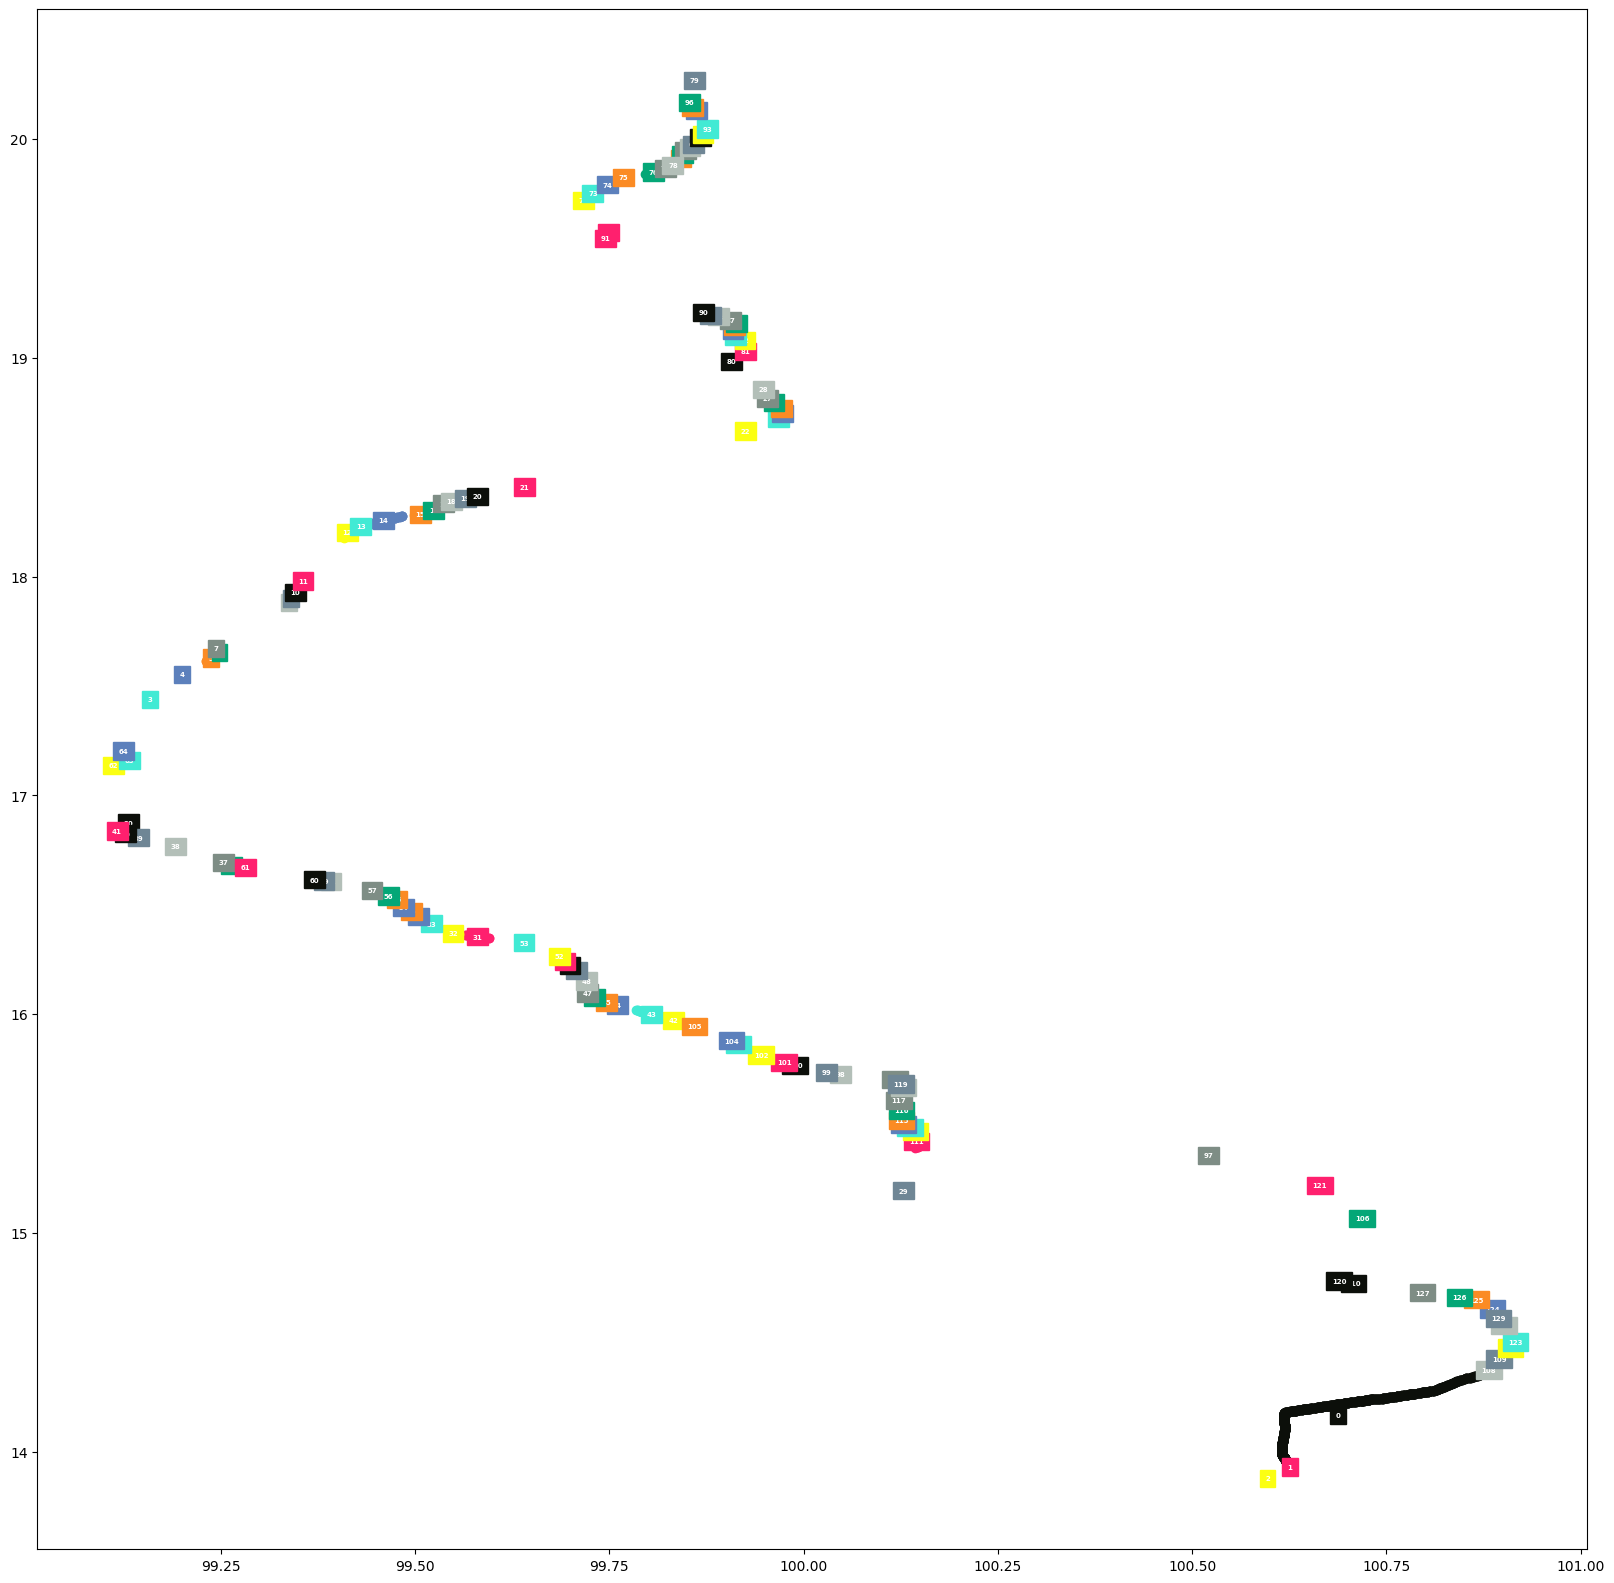

In [114]:
df_dbscan = dbscan(df_neighbors, 0.005, 8)

In [116]:
df_dbscan['label'].value_counts()

0      941
109     89
111     59
14      57
116     56
      ... 
94       8
97       8
101      8
13       8
59       6
Name: label, Length: 130, dtype: int64

In [98]:
df_neighbors[df_neighbors['label'] == -1]

,lat,lon,label
240,13.939,100.624,-1
284,13.977,100.618,-1
365,14.067,100.617,-1
687,13.939,100.624,-1
731,13.977,100.618,-1
...,...,...,...
4723,14.630,100.889,-1
4724,14.631,100.889,-1
4725,14.632,100.889,-1
4726,14.635,100.888,-1


In [35]:
df_neighbors

,rd,lat,lon,label
0,1,14.168,100.618,0
1,1,14.169,100.618,0
2,1,14.169,100.618,0
3,1,14.170,100.618,0
4,1,14.171,100.618,0
...,...,...,...,...
4753,1,14.662,100.887,124
4754,1,14.663,100.887,124
4755,1,14.664,100.887,124
4756,1,14.664,100.887,124
